# Librerías

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix
from sklearn.linear_model import LogisticRegression
import seaborn as sns

## Configuraciones

In [2]:
pd.set_option('display.max_columns',100)

In [3]:
pd.set_option('display.float_format',lambda num: '%.4f' %num)

# Lectura de datos

In [4]:
df = pd.read_csv('fraudT.csv' , sep = "|")

In [5]:
df.shape

(1403246, 23)

In [6]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.9700,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.0113,-82.0483,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.2300,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.1590,-118.1865,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.1100,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.1507,-112.1545,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.0000,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.0343,-112.5611,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.9600,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.6750,-78.6325,0


## Diccionario de datos

- index - Unique Identifier for each row
- transdatetrans_time - Transaction DateTime
- cc_num - Credit Card Number of Customer
- merchant - Merchant Name
- category - Category of Merchant
- amt - Amount of Transaction
- first - First Name of Credit Card Holder
- last - Last Name of Credit Card Holder
- gender - Gender of Credit Card Holder
- street - Street Address of Credit Card Holder
- city - City of Credit Card Holder
- state - State of Credit Card Holder
- zip - Zip of Credit Card Holder
- lat - Latitude Location of Credit Card Holder
- long - Longitude Location of Credit Card Holder
- city_pop - Credit Card Holder's City Population
- job - Job of Credit Card Holder
- dob - Date of Birth of Credit Card Holder
- trans_num - Transaction Number
- unix_time - UNIX Time of transaction
- merch_lat - Latitude Location of Merchant
- merch_long - Longitude Location of Merchant
- is_fraud - Fraud Flag <--- Target Class

In [7]:
df['is_fraud'].value_counts(), df['is_fraud'].value_counts(True)

(0    1289169
 1     114077
 Name: is_fraud, dtype: int64,
 0   0.9187
 1   0.0813
 Name: is_fraud, dtype: float64)

In [8]:
df.dtypes

Unnamed: 0                 int64
trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object

In [9]:
df.rename( columns={'Unnamed: 0':'id'} , inplace=True  )

In [10]:
df['id'] = df['id']+1

In [11]:
df['trans_date_trans_time']  = pd.to_datetime(  df['trans_date_trans_time']  )

# Ingeniería de variables

In [12]:
df['hour'] = df['trans_date_trans_time'].map( lambda x: x.strftime('%H') )

In [13]:
df['weekday'] = df['trans_date_trans_time'].map( lambda x: x.weekday() )

In [14]:
df['month'] = df['trans_date_trans_time'].map( lambda x: x.month )

In [15]:
df['year'] = df['trans_date_trans_time'].map( lambda x: x.year )

In [16]:
df['weekdayl'] = df['weekday'].map( dict(zip( range(7) , 'LMXJVSD' ))  )

In [17]:
df['numuse'] = df.sort_values(['cc_num','trans_date_trans_time'],ascending=[1,1]).groupby(['cc_num']).cumcount() + 1

In [18]:
df['age'] = (df['trans_date_trans_time'] - pd.to_datetime(df['dob']) ) / np.timedelta64(1,'Y')

In [19]:
df['zip'] = df['zip'].map( lambda x: '0'+str(x) if len(str(x))==4 else str(x)   )

In [20]:
df.rename(columns={'city_pop':'citypop',
                   'merch_lat':'merchlat',
                   'merch_long':'merchlong'},inplace=True)

# Variables

In [21]:
um = ['id']
# Discretas
vard = ['cc_num','merchant','category','gender','street','city','state','zip','job','hour','month','year','weekdayl']
# Continuas
varc = ['amt','lat','long','citypop','merchlat','merchlong','numuse','age']
# Variable objetivo
tgt = ['is_fraud']

v_fuera = ['trans_date_trans_time','first','last','dob','trans_num','unix_time','weekday']

# Análisis Exploratorio

## Discreto

### Frecuencia

In [22]:
def freq( df , var ):
    
    if type(var) != list:
        var = [var]
    
    for v in var:
        aux = df[v].value_counts().to_frame().rename(columns={v:'FA'})
        aux['FR'] = aux['FA'] / aux['FA'].sum()
        aux[['FAA','FRA']] = aux.apply( np.cumsum )
        print(f"\nFrecuencias para la variable {v}")
        display(aux)
        print("\n")

In [23]:
freq( df , vard )


Frecuencias para la variable cc_num


,FA,FR,FAA,FRA
2720433095629877,3342,0.0024,3342,0.0024
6538891242532018,3326,0.0024,6668,0.0048
6011438889172900,3321,0.0024,9989,0.0071
6534628260579800,3308,0.0024,13297,0.0095
630424987505,3293,0.0023,16590,0.0118
...,...,...,...,...
4975457191020,87,0.0001,1402945,0.9998
6577777028615915,82,0.0001,1403027,0.9998
180097223252063,78,0.0001,1403105,0.9999
6011732631674654,73,0.0001,1403178,1.0000





Frecuencias para la variable merchant


,FA,FR,FAA,FRA
fraud_Kilback LLC,5087,0.0036,5087,0.0036
fraud_Cormier LLC,4346,0.0031,9433,0.0067
fraud_Kuhn LLC,4125,0.0029,13558,0.0097
fraud_Schumm PLC,4095,0.0029,17653,0.0126
fraud_Boyer PLC,4084,0.0029,21737,0.0155
...,...,...,...,...
fraud_Treutel-King,800,0.0006,1400130,0.9978
"fraud_Medhurst, Labadie and Gottlieb",790,0.0006,1400920,0.9983
"fraud_Hodkiewicz, Prohaska and Paucek",787,0.0006,1401707,0.9989
"fraud_Ritchie, Bradtke and Stiedemann",786,0.0006,1402493,0.9995





Frecuencias para la variable category


,FA,FR,FAA,FRA
grocery_pos,148867,0.1061,148867,0.1061
gas_transport,140499,0.1001,289366,0.2062
shopping_pos,128605,0.0916,417971,0.2979
home,126027,0.0898,543998,0.3877
shopping_net,121566,0.0866,665564,0.4743
kids_pets,116398,0.0829,781962,0.5573
entertainment,97323,0.0694,879285,0.6266
personal_care,93850,0.0669,973135,0.6935
food_dining,93664,0.0667,1066799,0.7602
health_fitness,87621,0.0624,1154420,0.8227





Frecuencias para la variable gender


,FA,FR,FAA,FRA
F,763190,0.5439,763190,0.5439
M,640056,0.4561,1403246,1.0000





Frecuencias para la variable street


,FA,FR,FAA,FRA
854 Walker Dale Suite 488,3342,0.0024,3342,0.0024
5796 Lee Coves Apt. 286,3326,0.0024,6668,0.0048
40624 Rebecca Spurs,3321,0.0024,9989,0.0071
29606 Martinez Views Suite 653,3308,0.0024,13297,0.0095
2870 Bean Terrace Apt. 756,3293,0.0023,16590,0.0118
...,...,...,...,...
3437 Ross Flat Apt. 592,87,0.0001,1402945,0.9998
5124 Wendy Skyway Suite 154,82,0.0001,1403027,0.9998
7281 Joshua Mills Apt. 077,78,0.0001,1403105,0.9999
5273 Joseph Isle Suite 518,73,0.0001,1403178,1.0000





Frecuencias para la variable city


,FA,FR,FAA,FRA
Birmingham,5771,0.0041,5771,0.0041
San Antonio,5486,0.0039,11257,0.0080
Utica,5454,0.0039,16711,0.0119
Meridian,5267,0.0038,21978,0.0157
Phoenix,5101,0.0036,27079,0.0193
...,...,...,...,...
Norfolk,87,0.0001,1402945,0.9998
Karns City,82,0.0001,1403027,0.9998
Streator,78,0.0001,1403105,0.9999
Claypool,73,0.0001,1403178,1.0000





Frecuencias para la variable state


,FA,FR,FAA,FRA
TX,101818,0.0726,101818,0.0726
NY,91630,0.0653,193448,0.1379
PA,86256,0.0615,279704,0.1993
CA,60946,0.0434,340650,0.2428
OH,51106,0.0364,391756,0.2792
MI,49507,0.0353,441263,0.3145
IL,46806,0.0334,488069,0.3478
FL,46607,0.0332,534676,0.3810
AL,44070,0.0314,578746,0.4124
MO,41205,0.0294,619951,0.4418





Frecuencias para la variable zip


,FA,FR,FAA,FRA
48088,3926,0.0028,3926,0.0028
73754,3880,0.0028,7806,0.0056
82514,3870,0.0028,11676,0.0083
34112,3853,0.0027,15529,0.0111
04287,3342,0.0024,18871,0.0134
...,...,...,...,...
23523,87,0.0001,1402945,0.9998
16041,82,0.0001,1403027,0.9998
61364,78,0.0001,1403105,0.9999
46510,73,0.0001,1403178,1.0000





Frecuencias para la variable job


,FA,FR,FAA,FRA
Film/video editor,10440,0.0074,10440,0.0074
Exhibition designer,9926,0.0071,20366,0.0145
"Surveyor, land/geomatics",9452,0.0067,29818,0.0212
Naval architect,9450,0.0067,39268,0.0280
Materials engineer,9170,0.0065,48438,0.0345
...,...,...,...,...
Armed forces technical officer,114,0.0001,1402834,0.9997
Warehouse manager,113,0.0001,1402947,0.9998
Forest/woodland manager,111,0.0001,1403058,0.9999
Veterinary surgeon,106,0.0001,1403164,0.9999





Frecuencias para la variable hour


,FA,FR,FAA,FRA
22,93988,0.0670,93988,0.0670
23,93817,0.0669,187805,0.1338
18,67159,0.0479,254964,0.1817
16,66869,0.0477,321833,0.2293
17,66654,0.0475,388487,0.2768
19,66627,0.0475,455114,0.3243
21,66605,0.0475,521719,0.3718
15,66553,0.0474,588272,0.4192
13,66414,0.0473,654686,0.4666
12,66225,0.0472,720911,0.5137





Frecuencias para la variable month


,FA,FR,FAA,FRA
5,160169,0.1141,160169,0.1141
3,157131,0.1120,317300,0.2261
6,153688,0.1095,470988,0.3356
12,149216,0.1063,620204,0.4420
4,144606,0.1031,764810,0.5450
1,116639,0.0831,881449,0.6282
2,109675,0.0782,991124,0.7063
8,92747,0.0661,1083871,0.7724
7,91340,0.0651,1175211,0.8375
9,76657,0.0546,1251868,0.8921





Frecuencias para la variable year


,FA,FR,FAA,FRA
2019,998951,0.7119,998951,0.7119
2020,404295,0.2881,1403246,1.0000





Frecuencias para la variable weekdayl


,FA,FR,FAA,FRA
L,271098,0.1932,271098,0.1932
D,267915,0.1909,539013,0.3841
S,218159,0.1555,757172,0.5396
M,173659,0.1238,930831,0.6633
V,167517,0.1194,1098348,0.7827
J,161385,0.1150,1259733,0.8977
X,143513,0.1023,1403246,1.0000


In [24]:
def normalizar(df,v,umbral):

    aux = df[v].value_counts(True).to_frame()
    aux[f'n_{v}'] = np.where( aux[v] < umbral , 'CATEGORIAS PEQUEÑAS' , aux.index )

    moda = aux.head(1)[f'n_{v}'].values[0]

    if aux.loc[ aux[f'n_{v}'] == 'CATEGORIAS PEQUEÑAS'][v].sum() < umbral: 
        aux[f'n_{v}'].replace( { 'CATEGORIAS PEQUEÑAS': moda } , inplace=True)

    aux.drop( v , axis =1, inplace=True )
    aux.reset_index(inplace=True)

    return df.merge( aux, left_on=[v], right_on=['index'], how='inner' ).drop('index',axis=1)

In [25]:
for v in vard:
    df = normalizar(df,v,0.03)

In [26]:
varn = df.filter(like='n_').columns.tolist()

In [27]:
freq( df , varn )


Frecuencias para la variable n_cc_num


,FA,FR,FAA,FRA
CATEGORIAS PEQUEÑAS,1403246,1.0000,1403246,1.0000





Frecuencias para la variable n_merchant


,FA,FR,FAA,FRA
CATEGORIAS PEQUEÑAS,1403246,1.0000,1403246,1.0000





Frecuencias para la variable n_category


,FA,FR,FAA,FRA
grocery_pos,148867,0.1061,148867,0.1061
gas_transport,140499,0.1001,289366,0.2062
shopping_pos,128605,0.0916,417971,0.2979
home,126027,0.0898,543998,0.3877
shopping_net,121566,0.0866,665564,0.4743
kids_pets,116398,0.0829,781962,0.5573
entertainment,97323,0.0694,879285,0.6266
personal_care,93850,0.0669,973135,0.6935
food_dining,93664,0.0667,1066799,0.7602
health_fitness,87621,0.0624,1154420,0.8227





Frecuencias para la variable n_gender


,FA,FR,FAA,FRA
F,763190,0.5439,763190,0.5439
M,640056,0.4561,1403246,1.0000





Frecuencias para la variable n_street


,FA,FR,FAA,FRA
CATEGORIAS PEQUEÑAS,1403246,1.0000,1403246,1.0000





Frecuencias para la variable n_city


,FA,FR,FAA,FRA
CATEGORIAS PEQUEÑAS,1403246,1.0000,1403246,1.0000





Frecuencias para la variable n_state


,FA,FR,FAA,FRA
CATEGORIAS PEQUEÑAS,824500,0.5876,824500,0.5876
TX,101818,0.0726,926318,0.6601
NY,91630,0.0653,1017948,0.7254
PA,86256,0.0615,1104204,0.7869
CA,60946,0.0434,1165150,0.8303
OH,51106,0.0364,1216256,0.8667
MI,49507,0.0353,1265763,0.9020
IL,46806,0.0334,1312569,0.9354
FL,46607,0.0332,1359176,0.9686
AL,44070,0.0314,1403246,1.0000





Frecuencias para la variable n_zip


,FA,FR,FAA,FRA
CATEGORIAS PEQUEÑAS,1403246,1.0000,1403246,1.0000





Frecuencias para la variable n_job


,FA,FR,FAA,FRA
CATEGORIAS PEQUEÑAS,1403246,1.0000,1403246,1.0000





Frecuencias para la variable n_hour


,FA,FR,FAA,FRA
22,93988,0.0670,93988,0.0670
23,93817,0.0669,187805,0.1338
18,67159,0.0479,254964,0.1817
16,66869,0.0477,321833,0.2293
17,66654,0.0475,388487,0.2768
19,66627,0.0475,455114,0.3243
21,66605,0.0475,521719,0.3718
15,66553,0.0474,588272,0.4192
13,66414,0.0473,654686,0.4666
12,66225,0.0472,720911,0.5137





Frecuencias para la variable n_month


,FA,FR,FAA,FRA
5,160169,0.1141,160169,0.1141
3,157131,0.1120,317300,0.2261
6,153688,0.1095,470988,0.3356
12,149216,0.1063,620204,0.4420
4,144606,0.1031,764810,0.5450
1,116639,0.0831,881449,0.6282
2,109675,0.0782,991124,0.7063
8,92747,0.0661,1083871,0.7724
7,91340,0.0651,1175211,0.8375
9,76657,0.0546,1251868,0.8921





Frecuencias para la variable n_year


,FA,FR,FAA,FRA
2019,998951,0.7119,998951,0.7119
2020,404295,0.2881,1403246,1.0000





Frecuencias para la variable n_weekdayl


,FA,FR,FAA,FRA
L,271098,0.1932,271098,0.1932
D,267915,0.1909,539013,0.3841
S,218159,0.1555,757172,0.5396
M,173659,0.1238,930831,0.6633
V,167517,0.1194,1098348,0.7827
J,161385,0.1150,1259733,0.8977
X,143513,0.1023,1403246,1.0000


### Unarias

In [28]:
unarias = [  v for v, conteo in zip( varn , [ df[v].unique().shape[0] for v in varn ] ) if conteo == 1 ]

In [29]:
unarias

['n_cc_num', 'n_merchant', 'n_street', 'n_city', 'n_zip', 'n_job']

In [30]:
varn = [ v for v in varn if v not in unarias]

In [31]:
varn

['n_category',
 'n_gender',
 'n_state',
 'n_hour',
 'n_month',
 'n_year',
 'n_weekdayl']

## Continuo

### Discretizar

In [32]:
from sklearn.preprocessing import KBinsDiscretizer

In [33]:
def discretizar(df, v, k):

    kb = KBinsDiscretizer( n_bins= k , encode='ordinal', strategy='quantile')
    kb.fit(df[[v]])
    df[f'd_{v}_{k}'] = pd.cut(  df[v] , bins=kb.bin_edges_[0] , include_lowest=True  ).astype(str)
    
    return df

In [34]:
for v in varc:
    for k in range(2,6):
        df = discretizar( df , v , k )

/home/luis/Documentos/entornos/env_modulo_1/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:216: FutureWarning: In version 1.3 onwards, subsample=2e5 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/home/luis/Documentos/entornos/env_modulo_1/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:216: FutureWarning: In version 1.3 onwards, subsample=2e5 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/home/luis/Documentos/entornos/env_modulo_1/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:216: FutureWarning: In version 1.3 onwards, subsample=2e5 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.w

/home/luis/Documentos/entornos/env_modulo_1/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:216: FutureWarning: In version 1.3 onwards, subsample=2e5 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/home/luis/Documentos/entornos/env_modulo_1/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:216: FutureWarning: In version 1.3 onwards, subsample=2e5 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/home/luis/Documentos/entornos/env_modulo_1/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:216: FutureWarning: In version 1.3 onwards, subsample=2e5 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.w

In [35]:
df.head()

,id,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,citypop,job,dob,trans_num,unix_time,merchlat,merchlong,is_fraud,hour,weekday,month,year,weekdayl,numuse,age,n_cc_num,n_merchant,n_category,n_gender,n_street,n_city,n_state,n_zip,n_job,n_hour,n_month,n_year,n_weekdayl,d_amt_2,d_amt_3,d_amt_4,d_amt_5,d_lat_2,d_lat_3,d_lat_4,d_lat_5,d_long_2,d_long_3,d_long_4,d_long_5,d_citypop_2,d_citypop_3,d_citypop_4,d_citypop_5,d_merchlat_2,d_merchlat_3,d_merchlat_4,d_merchlat_5,d_merchlong_2,d_merchlong_3,d_merchlong_4,d_merchlong_5,d_numuse_2,d_numuse_3,d_numuse_4,d_numuse_5,d_age_2,d_age_3,d_age_4,d_age_5
0,1,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.9700,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.0113,-82.0483,0,00,1,1,2019,M,1,30.8151,CATEGORIAS PEQUEÑAS,CATEGORIAS PEQUEÑAS,misc_net,F,CATEGORIAS PEQUEÑAS,CATEGORIAS PEQUEÑAS,CATEGORIAS PEQUEÑAS,CATEGORIAS PEQUEÑAS,CATEGORIAS PEQUEÑAS,00,1,2019,M,"(0.999, 50.64]","(0.999, 22.8]","(0.999, 10.64]","(0.999, 8.26]","(20.026, 39.372]","(20.026, 36.522]","(34.669, 39.372]","(33.906, 38.243]","(-87.458, -67.95]","(-82.092, -67.95]","(-87.458, -80.138]","(-84.092, -78.778]","(2456.0, 2906700.0]","(1179.0, 6951.0]","(2456.0, 20328.0]","(1631.0, 4726.0]","(19.026999999999997, 39.373]","(19.026999999999997, 36.627]","(34.759, 39.373]","(33.836, 38.062]","(-87.393, -66.951]","(-82.191, -66.951]","(-87.393, -80.211]","(-84.047, -78.783]","(0.999, 806.0]","(0.999, 503.0]","(0.999, 374.0]","(0.999, 297.0]","(13.922, 44.201]","(13.922, 35.729]","(13.922, 32.629]","(30.579, 39.398]"
1,68,2019-01-01 00:48:09,4707867759656333,fraud_Huel-Langworth,misc_net,303.4700,Susan,Shah,F,9016 Jordan Bypass Apt. 516,Cranks,KY,40820,36.7558,-83.1838,581,"Psychologist, counselling",1967-02-04,cdb332a151bdd568d98837b9e19043b8,1325378889,36.3942,-82.5143,0,00,1,1,2019,M,1,51.9081,CATEGORIAS PEQUEÑAS,CATEGORIAS PEQUEÑAS,misc_net,F,CATEGORIAS PEQUEÑAS,CATEGORIAS PEQUEÑAS,CATEGORIAS PEQUEÑAS,CATEGORIAS PEQUEÑAS,CATEGORIAS PEQUEÑAS,00,1,2019,M,"(50.64, 28948.9]","(75.48, 28948.9]","(93.03, 28948.9]","(109.84, 28948.9]","(20.026, 39.372]","(36.522, 41.044]","(34.669, 39.372]","(33.906, 38.243]","(-87.458, -67.95]","(-93.674, -82.092]","(-87.458, -80.138]","(-84.092, -78.778]","(22.999, 2456.0]","(22.999, 1179.0]","(22.999, 743.0]","(566.0, 1631.0]","(19.026999999999997, 39.373]","(19.026999999999997, 36.627]","(34.759, 39.373]","(33.836, 38.062]","(-87.393, -66.951]","(-93.752, -82.191]","(-87.393, -80.211]","(-84.047, -78.783]","(0.999, 806.0]","(0.999, 503.0]","(0.999, 374.0]","(0.999, 297.0]","(44.201, 95.642]","(35.729, 51.914]","(44.201, 57.444]","(48.034, 61.067]"
2,26,2019-01-01 00:18:07,343464013864032,fraud_Kunde-Sanford,misc_net,2.5500,Jodi,Foster,F,551 Zachary Freeway,Bailey,NC,27807,35.8072,-78.0892,6629,Call centre manager,1962-08-13,abe0676c18f34fa305b113fa762e29b5,1325377087,36.7499,-78.6779,0,00,1,1,2019,M,1,56.3872,CATEGORIAS PEQUEÑAS,CATEGORIAS PEQUEÑAS,misc_net,F,CATEGORIAS PEQUEÑAS,CATEGORIAS PEQUEÑAS,CATEGORIAS PEQUEÑAS,CATEGORIAS PEQUEÑAS,CATEGORIAS PEQUEÑAS,00,1,2019,M,"(0.999, 50.64]","(0.999, 22.8]","(0.999, 10.64]","(0.999, 8.26]","(20.026, 39.372]","(20.026, 36.522]","(34.669, 39.372]","(33.906, 38.243]","(-87.458, -67.95]","(-82.092, -67.95]","(-80.138, -67.95]","(-78.778, -67.95]","(2456.0, 2906700.0]","(1179.0, 6951.0]","(2456.0, 20328.0]","(4726.0, 42384.0]","(19.026999999999997, 39.373]","(36.627, 41.057]","(34.759, 39.373]","(33.836, 38.062]","(-87.393, -66.951]","(-82.191, -66.951]","(-80.211, -66.951]","(-78.783, -66.951]","(0.999, 806.0]","(0.999, 503.0]","(0.999, 374.0]","(0.999, 297.0]","(44.201, 95.642]","(51.914, 95.642]","(44.201, 57.444]","(48.034, 61.067]"
3,36076,2019-01-22 00:33:05,6011109736646996,fraud_Stiedemann Inc,misc_pos,9.6100,Rebecca,Erickson,F,594 Berry Lights Apt. 392,

In [36]:
vari = df.filter(like='d_').columns.to_list()

In [37]:
vari

['d_amt_2',
 'd_amt_3',
 'd_amt_4',
 'd_amt_5',
 'd_lat_2',
 'd_lat_3',
 'd_lat_4',
 'd_lat_5',
 'd_long_2',
 'd_long_3',
 'd_long_4',
 'd_long_5',
 'd_citypop_2',
 'd_citypop_3',
 'd_citypop_4',
 'd_citypop_5',
 'd_merchlat_2',
 'd_merchlat_3',
 'd_merchlat_4',
 'd_merchlat_5',
 'd_merchlong_2',
 'd_merchlong_3',
 'd_merchlong_4',
 'd_merchlong_5',
 'd_numuse_2',
 'd_numuse_3',
 'd_numuse_4',
 'd_numuse_5',
 'd_age_2',
 'd_age_3',
 'd_age_4',
 'd_age_5']

## IV - Función

In [38]:
def calculo_iv( df, v, tgt, um ):

    aux =  df.pivot_table( index   = v,
                           columns = tgt,
                           values  = um[0],
                           aggfunc = 'count',
                           fill_value = 0
                           )

    aux[  list(range(2)) ] = aux/aux.apply(np.sum)

    aux['w'] = np.log( aux[0] / aux[1] )

    aux['iv'] = ( aux[0] - aux[1]) * aux['w']
    
    return v, aux['iv'].sum()

# Partición de datos

## Las mejores variables 

In [39]:
X = df[ um + vari ].copy()
y = df[ um + tgt].copy()

Xt, Xv, yt, yv = train_test_split(X, y, train_size=.7)

In [40]:
Xt.shape, Xv.shape, yt.shape[0], yv.shape[0]

((982272, 33), (420974, 33), 982272, 420974)

In [41]:
Xt =  Xt.merge( yt, on = um , how='inner').reset_index(drop=True)

In [42]:
# IV de discretizadas -> vari
iv = pd.DataFrame( map( lambda v: calculo_iv( df, v, tgt, um ) , vari   ) , columns=['variable','iv']   )
iv['raiz'] = iv['variable'].map( lambda x: '_'.join(x.split('_')[1:2]) )
iv = iv.sort_values(by=['raiz','iv'], ascending=[1,0]).reset_index(drop=True)
# Eliminación de infs
iv = iv.loc[iv['iv'] != np.inf].reset_index(drop=True)
iv['id'] = iv.groupby('raiz').cumcount()+1
iv = iv.loc[ iv.id == 1]

In [43]:
iv.drop(columns=['raiz','id'],inplace=True)

In [44]:
iv

,variable,iv
0,d_age_5,0.0615
4,d_amt_5,2.8566
8,d_citypop_3,0.0017
12,d_lat_5,0.0019
16,d_long_5,0.0041
20,d_merchlat_4,0.0016
24,d_merchlong_5,0.0037
28,d_numuse_5,0.1991


In [45]:
besti = iv['variable'].tolist()

In [46]:
len(besti), besti

(8,
 ['d_age_5',
  'd_amt_5',
  'd_citypop_3',
  'd_lat_5',
  'd_long_5',
  'd_merchlat_4',
  'd_merchlong_5',
  'd_numuse_5'])

In [47]:
X[besti]

,d_age_5,d_amt_5,d_citypop_3,d_lat_5,d_long_5,d_merchlat_4,d_merchlong_5,d_numuse_5
0,"(30.579, 39.398]","(0.999, 8.26]","(1179.0, 6951.0]","(33.906, 38.243]","(-84.092, -78.778]","(34.759, 39.373]","(-84.047, -78.783]","(0.999, 297.0]"
1,"(48.034, 61.067]","(109.84, 28948.9]","(22.999, 1179.0]","(33.906, 38.243]","(-84.092, -78.778]","(34.759, 39.373]","(-84.047, -78.783]","(0.999, 297.0]"
2,"(48.034, 61.067]","(0.999, 8.26]","(1179.0, 6951.0]","(33.906, 38.243]","(-78.778, -67.95]","(34.759, 39.373]","(-78.783, -66.951]","(0.999, 297.0]"
3,"(30.579, 39.398]","(8.26, 34.7]","(6951.0, 2906700.0]","(33.906, 38.243]","(-78.778, -67.95]","(34.759, 39.373]","(-78.783, -66.951]","(0.999, 297.0]"
4,"(30.579, 39.398]","(34.7, 65.42]","(6951.0, 2906700.0]","(33.906, 38.243]","(-78.778, -67.95]","(19.026999999999997, 34.759]","(-78.783, -66.951]","(0.999, 297.0]"
...,...,...,...,...,...,...,...,...
1403241,"(48.034, 61.067]","(65.42, 109.84]","(6951.0, 2906700.0]","(42.685, 66.693]","(-98.739, -91.024]","(41.96, 67.51]","(-98.798, -91.037]","(297.0, 613.0]"
1403242,"(30.579, 39.398]","(65.42, 109.84]","(6951.0, 2906700.0]","(20.026, 33.906]","(-165.673, -98.739]","(19.026999999999997, 34.759]","(-166.672, -98.798]","(1540.0, 3342.0]"
1403243,"(48.034, 61.067]","(8.26, 34.7]","(22.999, 1179.0]","(33.906, 38.243]","(-165.673, -98.739]","(34.759, 39.373]","(-166.672, -98.798]","(613.0, 1010.0]"
1403244,"(30.579, 39.398]","(0.999, 8.26]","(6951.0, 2906700.0]","(33.906, 38.243]","(-165.673, -98.739]","(19.026999999999997, 34.759]","(-166.672, -98.798]","(1540.0, 3342.0]"


## Las mejores variables finales

In [48]:
X = df[ um + vari ].copy()
y = df[ um + tgt].copy()

Xt, Xv, yt, yv = train_test_split(X, y, train_size=.7)

In [49]:
Xt.shape, Xv.shape, yt.shape[0], yv.shape[0]

((982272, 33), (420974, 33), 982272, 420974)

In [50]:
Xt =  Xt.merge( yt, on = um , how='inner').reset_index(drop=True)

In [51]:
# IV de normalizadas -> varn
iv2 = pd.DataFrame( map( lambda v: calculo_iv( df, v, tgt, um ) , varn   ) , columns=['variable','iv']   )

In [52]:
iv2

,variable,iv
0,n_category,0.7571
1,n_gender,0.0091
2,n_state,0.0057
3,n_hour,1.8446
4,n_month,0.0603
5,n_year,0.0016
6,n_weekdayl,0.0244


In [53]:
iv = pd.concat( [iv,iv2] , ignore_index=True )

In [54]:
iv = iv.sort_values(by='iv',ascending=False).reset_index(drop=True)

In [55]:
iv

,variable,iv
0,d_amt_5,2.8566
1,n_hour,1.8446
2,n_category,0.7571
3,d_numuse_5,0.1991
4,d_age_5,0.0615
5,n_month,0.0603
6,n_weekdayl,0.0244
7,n_gender,0.0091
8,n_state,0.0057
9,d_long_5,0.0041


In [56]:
# Descarte de variables

In [57]:
iv_final = iv.loc[ (iv['iv'] >=0.0001) & (iv['iv'] <= 3.8 ) ].reset_index(drop=True)

In [58]:
iv_final

,variable,iv
0,d_amt_5,2.8566
1,n_hour,1.8446
2,n_category,0.7571
3,d_numuse_5,0.1991
4,d_age_5,0.0615
5,n_month,0.0603
6,n_weekdayl,0.0244
7,n_gender,0.0091
8,n_state,0.0057
9,d_long_5,0.0041


In [59]:
best = iv_final['variable'].tolist()

In [60]:
best

['d_amt_5',
 'n_hour',
 'n_category',
 'd_numuse_5',
 'd_age_5',
 'n_month',
 'n_weekdayl',
 'n_gender',
 'n_state',
 'd_long_5',
 'd_merchlong_5',
 'd_lat_5',
 'd_citypop_3',
 'd_merchlat_4',
 'n_year']

# Transformación WoE

In [61]:
X = df[ um + best ].copy()
y = df[ um + tgt].copy()

Xt, Xv, yt, yv = train_test_split(X, y, train_size=.7)

print(Xt.shape, Xv.shape, yt.shape[0], yv.shape[0])

Xt =  Xt.merge( yt, on = um , how='inner').reset_index(drop=True)

(982272, 16) (420974, 16) 982272 420974


In [62]:
def codificacion_woe( df, v, tgt, um ):

    aux = df.pivot_table( index= v,
                          columns = tgt,
                          values = um[0],
                         aggfunc = 'count',
                         fill_value = 0)

    aux[list(range(2))] = aux / aux.apply(np.sum)

    aux['w'] = np.log( aux[0] / aux[1] )

    aux.drop(range(2),axis=1, inplace=True)

    aux = aux.to_dict()['w']

    return v , aux

In [63]:
mapa_woe = list( map(  lambda v: codificacion_woe( Xt, v, tgt, um ) , best  ) )

In [64]:
mapa_woe

[('d_amt_5',
  {'(0.999, 8.26]': 1.9114957125790593,
   '(109.84, 28948.9]': -1.6509426720651263,
   '(34.7, 65.42]': 2.9308751577258625,
   '(65.42, 109.84]': 4.048736771146781,
   '(8.26, 34.7]': 0.14303044416030988}),
 ('n_hour',
  {'00': -0.9778948291163226,
   '01': -0.9900117886963191,
   '02': -0.9704360266626328,
   '03': -0.9187746085515738,
   '04': 1.6606928428425793,
   '05': 1.4562811483835274,
   '06': 1.8632400738970492,
   '07': 1.4248811600660212,
   '08': 1.5653703416416798,
   '09': 1.6513598879298017,
   '10': 1.7743382095440274,
   '11': 1.769665119734682,
   '12': 1.6923897706474578,
   '13': 1.6071689533229045,
   '14': 1.4765761631987624,
   '15': 1.5461306463732682,
   '16': 1.5655707043763998,
   '17': 1.5268441412786082,
   '18': 1.6007494769784114,
   '19': 1.5777330930617968,
   '20': 1.7985678029286445,
   '21': 1.6415110501608272,
   '22': -1.6217705057655012,
   '23': -1.6042255603238709}),
 ('n_category',
  {'entertainment': 0.8484465722122074,
   'food

In [65]:
for v, mapa in mapa_woe:
    Xt[f'w_{v}'] = Xt[v].replace(mapa)
    Xv[f'w_{v}'] = Xv[v].replace(mapa)

In [66]:
print(Xt.shape, Xv.shape, yt.shape[0], yv.shape[0])

(982272, 32) (420974, 31) 982272 420974


In [67]:
varw = Xt.filter(like='w_').columns.tolist()

# TAD

In [68]:
tad_1 = Xt[ um + varw ].merge( yt , on=um , how='inner' )

In [69]:
tad_1

,id,w_d_amt_5,w_n_hour,w_n_category,w_d_numuse_5,w_d_age_5,w_n_month,w_n_weekdayl,w_n_gender,w_n_state,w_d_long_5,w_d_merchlong_5,w_d_lat_5,w_d_citypop_3,w_d_merchlat_4,w_n_year,is_fraud
0,1324399,-1.6509,1.5654,-0.9221,0.4835,0.2922,-0.0472,-0.1421,-0.1039,0.0089,0.0729,0.0593,0.0790,0.0346,0.0704,0.0271,1
1,741450,0.1430,-1.6042,0.8484,0.6703,0.3558,0.0224,-0.0222,-0.1039,0.0089,-0.0743,-0.0809,-0.0206,-0.0505,-0.0186,0.0271,0
2,756615,0.1430,1.4766,1.0134,0.6703,0.3558,0.0224,-0.0222,0.0947,0.0329,-0.0743,-0.0809,0.0102,-0.0505,-0.0139,0.0271,0
3,204960,0.1430,-1.6042,1.0134,-0.2891,0.3558,0.1357,0.1739,0.0947,0.0329,-0.0743,-0.0809,0.0102,-0.0505,-0.0139,0.0271,0
4,1052147,2.9309,1.6072,1.2657,0.6703,0.3558,-0.1117,-0.1421,0.0947,0.0089,-0.0652,-0.0513,-0.0616,0.0346,-0.0350,-0.0644,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
982267,1006736,1.9115,1.5656,1.0134,0.6703,0.2922,-0.4136,0.2070,-0.1039,0.1185,0.0729,0.0586,0.0790,-0.0505,0.0704,-0.0644,0
982268,942654,-1.6509,1.6415,1.2530,0.4835,-0.2275,-0.3269,-0.0406,0.0947,0.0089,0.0533,0.0593,-0.0616,0.0172,-0.0350,-0.0644,0
982269,394055,1.9115,1.6924,-1.1089,0.1038,-0.2275,0.1885,-0.0406,0.0947,-0.1638,-0.0743,-0.0809,-0.0025,-0.0505,-0.0139,0.0271,0
982270,1253538,2.9309,1.6607,-0.9221,0.4835,0.3558,0.1885,-0.0406,-0.1039,0.0089,0.0205,0.0210,0.0790,0.0346,0.0704,-0.0644,0


In [70]:
tad_1[tgt].value_counts()

is_fraud
0           902439
1            79833
dtype: int64

# Modelo

In [71]:
modelo = LogisticRegression()

In [72]:
modelo.fit( Xt[varw] , yt[tgt]  )

/home/luis/Documentos/entornos/env_modulo_1/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/luis/Documentos/entornos/env_modulo_1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [73]:
modelo.intercept_

array([-2.34422619])

In [74]:
modelo.coef_

array([[-0.87407108, -0.97256145, -0.50745487, -1.30316599, -0.31724801,
        -0.32713895, -0.97116307, -1.10933224, -0.12827001, -0.54329358,
        -0.28993037, -0.67278317, -0.12140051, -0.45567299, -7.74634284]])

In [75]:
pd.DataFrame(modelo.predict_proba(Xv[varw]))

,0,1
0,0.9992,0.0008
1,0.7343,0.2657
2,0.9991,0.0009
3,0.9937,0.0063
4,0.9933,0.0067
...,...,...
420969,0.9998,0.0002
420970,0.9990,0.0010
420971,0.9996,0.0004
420972,0.9963,0.0037


In [76]:
pd.DataFrame(modelo.predict(Xv[varw])).value_counts()

0    392648
1     28326
dtype: int64

In [77]:
rest_v = modelo.predict(Xv[varw])

In [78]:
unicos , counts = np.unique( rest_v , return_counts=True)

In [79]:
unicos, counts

(array([0, 1]), array([392648,  28326]))

## Evaluación 

In [80]:
from scikitplot.metrics import plot_roc_curve

/home/luis/Documentos/entornos/env_modulo_1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)
/home/luis/Documentos/entornos/env_modulo_1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

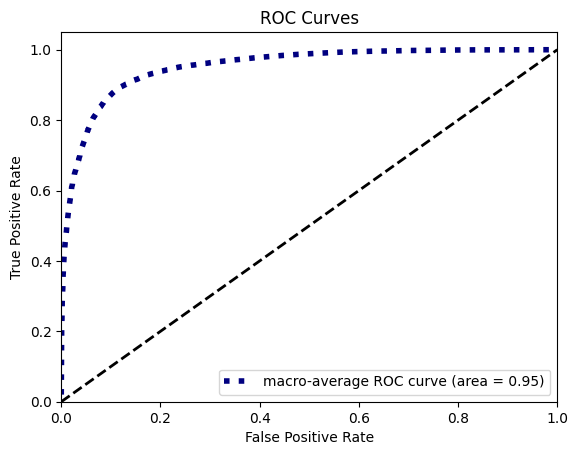

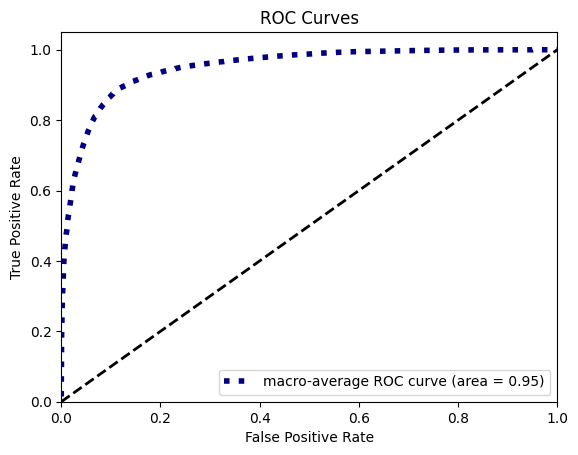

In [81]:
plot_roc_curve( y_true = yt[tgt] , y_probas = modelo.predict_proba( Xt[varw] ) , curves='macro'  )
plot_roc_curve( y_true = yv[tgt] , y_probas = modelo.predict_proba( Xv[varw] ) , curves='macro'  )

In [82]:
def metricas(model,Xv,yv):
    print(" Métricas para modelo de clasificación: \n")

    print(" Valor ROC : %.3f"   %roc_auc_score( y_score=model.predict_proba(Xv)[:,1] , y_true=yv  )   )

    print(" Valor ACC : %.3f\n" %accuracy_score( y_pred=model.predict(Xv) , y_true=yv) )

    print(" Matriz de confusión: ", "\n", confusion_matrix(y_pred=model.predict(Xv) , y_true=yv ) )

In [83]:
metricas(modelo , Xv[varw], yv[tgt])

 Métricas para modelo de clasificación: 

 Valor ROC : 0.950
 Valor ACC : 0.945

 Matriz de confusión:  
 [[378149   8581]
 [ 14499  19745]]


# Transformación a Scoring ( targeta de puntos )

In [84]:
PDO = 30
base_score = 700
base_odds = 2

factor = PDO / np.log(2)

offset = base_score - factor * np.log(base_odds)

print( factor, offset )

43.2808512266689 670.0


In [85]:
betas = modelo.coef_[0].tolist()
beta0 = modelo.intercept_[0]

In [86]:
betas , beta0

([-0.8740710820826791,
  -0.9725614454550324,
  -0.5074548746729612,
  -1.3031659858629103,
  -0.31724801434542843,
  -0.3271389502043326,
  -0.9711630708419251,
  -1.10933224447174,
  -0.12827001446086236,
  -0.543293579926145,
  -0.2899303698073004,
  -0.672783174610675,
  -0.12140050766996846,
  -0.4556729917762178,
  -7.746342838759818],
 -2.344226193032231)

In [87]:
n = len(betas)

In [88]:
for v, beta in zip(varw, betas):
    
    print(v, beta)
    
    Xt[f'p_{v}'] = np.ceil( ( -Xt[v]*beta+beta0/n ) * factor + offset / n )
    Xv[f'p_{v}'] = np.ceil( ( -Xv[v]*beta+beta0/n ) * factor + offset / n )

w_d_amt_5 -0.8740710820826791
w_n_hour -0.9725614454550324
w_n_category -0.5074548746729612
w_d_numuse_5 -1.3031659858629103
w_d_age_5 -0.31724801434542843
w_n_month -0.3271389502043326
w_n_weekdayl -0.9711630708419251
w_n_gender -1.10933224447174
w_n_state -0.12827001446086236
w_d_long_5 -0.543293579926145
w_d_merchlong_5 -0.2899303698073004
w_d_lat_5 -0.672783174610675
w_d_citypop_3 -0.12140050766996846
w_d_merchlat_4 -0.4556729917762178
w_n_year -7.746342838759818


In [89]:
varp = [c for c in Xt.columns.tolist() if c[:2] == 'p_']

In [90]:
Xt['score'] = Xt[varp].sum(axis=1)
Xv['score'] = Xv[varp].sum(axis=1)

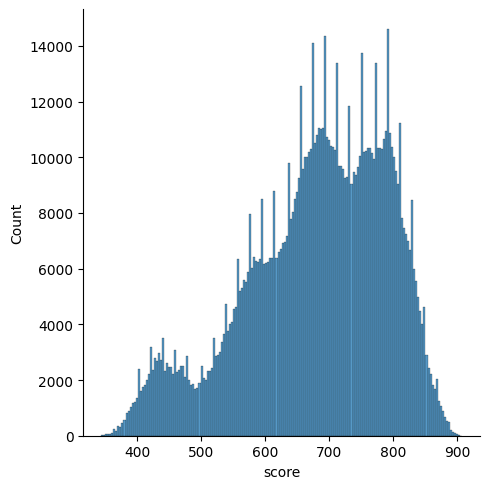

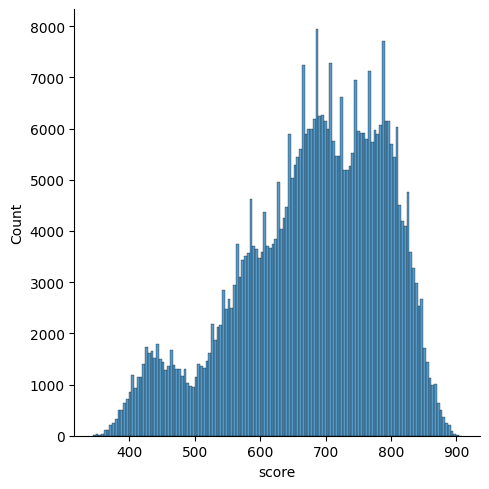

In [91]:
sns.displot(Xt['score'])
sns.displot(Xv['score'])

## Scorecard

In [92]:
lst = []

for vi, vp in zip( [v[2:] for v in varw], varp  ):
    aux = Xt[[vi,vp]].drop_duplicates()
    aux = aux.sort_values(by = vi , ascending=True).reset_index(drop=True)
    aux.columns = [ 'atributo','puntos']
    aux['caracteristica'] = vi
    lst.append(aux)

In [93]:
scorecard = pd.concat( lst , ignore_index=True )

In [94]:
scorecard = scorecard.groupby(['caracteristica','atributo']).sum('puntos')

In [95]:
scorecard.to_excel(os.path.join('scorecard_G19.xlsx'))

In [96]:
scorecard

puntos
caracteristica atributo                
d_age_5        (13.922, 30.579] 38.0000
               (30.579, 39.398] 43.0000
               (39.398, 48.034] 42.0000
               (48.034, 61.067] 35.0000
               (61.067, 95.642] 35.0000
...                                 ...
n_weekdayl     S                37.0000
               V                30.0000
               X                33.0000
n_year         2019             47.0000
               2020             17.0000

[108 rows x 1 columns]

## Validación de puntos

In [97]:
scr = scorecard.reset_index()

### Prueba variable amt

In [98]:
id_validacion = 496560

In [99]:
df.loc[df['id'] == id_validacion][ um + [c for c in df.filter(like='amt').columns.tolist() ] ]

,id,amt,d_amt_2,d_amt_3,d_amt_4,d_amt_5
809786,496560,61.9500,"(50.64, 28948.9]","(22.8, 75.48]","(50.64, 93.03]","(34.7, 65.42]"


In [100]:
Xv

,id,d_amt_5,n_hour,n_category,d_numuse_5,d_age_5,n_month,n_weekdayl,n_gender,n_state,d_long_5,d_merchlong_5,d_lat_5,d_citypop_3,d_merchlat_4,n_year,w_d_amt_5,w_n_hour,w_n_category,w_d_numuse_5,w_d_age_5,w_n_month,w_n_weekdayl,w_n_gender,w_n_state,w_d_long_5,w_d_merchlong_5,w_d_lat_5,w_d_citypop_3,w_d_merchlat_4,w_n_year,p_w_d_amt_5,p_w_n_hour,p_w_n_category,p_w_d_numuse_5,p_w_d_age_5,p_w_n_month,p_w_n_weekdayl,p_w_n_gender,p_w_n_state,p_w_d_long_5,p_w_d_merchlong_5,p_w_d_lat_5,p_w_d_citypop_3,p_w_d_merchlat_4,p_w_n_year,score
59574,225208,"(34.7, 65.42]",20,home,"(297.0, 613.0]","(61.067, 95.642]",4,M,F,PA,"(-78.778, -67.95]","(-78.783, -66.951]","(40.497, 42.685]","(1179.0, 6951.0]","(39.373, 41.96]",2019,2.9309,1.7986,1.2530,-0.2891,-0.2661,0.1357,-0.0222,0.0947,0.0329,-0.0743,-0.0809,-0.0025,0.0346,-0.0139,0.0271,149.0000,114.0000,66.0000,22.0000,35.0000,40.0000,37.0000,43.0000,39.0000,37.0000,37.0000,38.0000,39.0000,38.0000,47.0000,781.0000
1170686,64626,"(8.26, 34.7]",23,health_fitness,"(0.999, 297.0]","(30.579, 39.398]",2,J,M,TX,"(-98.739, -91.024]","(-98.798, -91.037]","(20.026, 33.906]","(6951.0, 2906700.0]","(19.026999999999997, 34.759]",2019,0.1430,-1.6042,1.4308,-0.5400,0.3558,-0.4136,-0.1421,-0.1039,0.1185,0.0729,0.0593,0.0790,-0.0505,0.0704,0.0271,44.0000,-29.0000,70.0000,8.0000,43.0000,33.0000,32.0000,33.0000,39.0000,40.0000,39.0000,41.0000,38.0000,40.0000,47.0000,518.0000
127286,1127264,"(34.7, 65.42]",05,grocery_net,"(1540.0, 3342.0]","(13.922, 30.579]",4,M,F,NY,"(-78.778, -67.95]","(-78.783, -66.951]","(40.497, 42.685]","(1179.0, 6951.0]","(39.373, 41.96]",2020,2.9309,1.4563,0.6084,0.6703,-0.0178,0.1357,-0.0222,0.0947,-0.1638,-0.0743,-0.0809,-0.0025,0.0346,-0.0139,-0.0644,149.0000,100.0000,52.0000,76.0000,38.0000,40.0000,37.0000,43.0000,37.0000,37.0000,37.0000,38.0000,39.0000,38.0000,17.0000,778.0000
197571,316318,"(0.999, 8.26]",18,shopping_net,"(297.0, 613.0]","(13.922, 30.579]",6,S,F,FL,"(-91.024, -84.092]","(-91.037, -84.047]","(20.026, 33.906]","(22.999, 1179.0]","(19.026999999999997, 34.759]",2019,1.9115,1.6007,-1.1089,-0.2891,-0.0178,0.1885,-0.0406,0.0947,-0.1110,0.0205,0.0210,0.0790,0.0172,0.0704,0.0271,111.0000,106.0000,14.0000,22.0000,38.0000,41.0000,37.0000,43.0000,38.0000,39.0000,39.0000,41.0000,38.0000,40.0000,47.0000,694.0000
106803,677301,"(8.26, 34.7]",15,kids_pets,"(613.0, 1010.0]","(39.398, 48.034]",10,M,F,CATEGORIAS PEQUEÑAS,"(-98.739, -91.024]","(-98.798, -91.037]","(42.685, 66.693]","(22.999, 1179.0]","(41.96, 67.51]",2019,0.1430,1.5461,1.0134,0.1038,0.2922,-0.1287,-0.0222,0.0947,0.0089,0.0729,0.0593,-0.0206,0.0172,-0.0186,0.0271,44.0000,103.0000,61.0000,44.0000,42.0000,37.0000,37.0000,43.0000,38.0000,40.0000,39.0000,38.0000,38.0000,38.0000,47.0000,689.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555781,738620,"(65.42, 109.84]",15,health_fitness,"(613.0, 1010.0]","(30.579, 39.398]",11,L,M,CATEGORIAS PEQUEÑAS,"(-84.092, -78.778]","(-84.047, -78.783]","(33.906, 38.243]","(22.999, 1179.0]","(34.759, 39.373]",2019,4.0487,1.5461,1.4308,0.1038,0.3558,0.0224,0.2070,-0.1039,0.0089,-0.0652,-0.0513,-0.0616,0.0172,-0.0350,0.0271,192.0000,103.0000,70.0000,44.0000,43.0000,39.0000,47.0000,33.0000,38.0000,37.0000,38.0000,37.0000,38.0000,38.0000,47.0000,844.0000
186581,334426,"(34.7, 65.42]",07,gas_transport,"(613.0, 1010.0]","(13.922, 30.579]",6,S,F,CATEGORIAS PEQUEÑAS,"(-165.673, -98.739]","(-166.672, -98.798]","(42.685, 66.693]","(22.999, 1179.0]","(41.96, 67.51]",2019,2.9309,1.4249,0.1931,0.1038,-0.0178,0.1885,-0.0406,0.0947,0.0089,0.0533,0.0586,-0.0206,0.0172,-0.0186,0.0271,149.0000,98.0000,43.0000,44.0000,38.0000,41.0000,37.0000,43.0000,38.0000,40.0000,39.0000,38.0000,38.0000,38.0000,47.0000,771.0000
1360799,679322,"(34.7, 65.42]",20,food_dining,"(1010.0, 1540.0]","(48.034, 61.067]",10,X,M,TX,"(-98.739, -91.024]","(-98.798, -91.037]","(20.026, 33.906

In [101]:
mapa_woe[0]

('d_amt_5',
 {'(0.999, 8.26]': 1.9114957125790593,
  '(109.84, 28948.9]': -1.6509426720651263,
  '(34.7, 65.42]': 2.9308751577258625,
  '(65.42, 109.84]': 4.048736771146781,
  '(8.26, 34.7]': 0.14303044416030988})

In [102]:
scr.loc[scr.caracteristica == 'd_amt_5' ]

,caracteristica,atributo,puntos
5,d_amt_5,"(0.999, 8.26]",111.0000
6,d_amt_5,"(109.84, 28948.9]",-24.0000
7,d_amt_5,"(34.7, 65.42]",149.0000
8,d_amt_5,"(65.42, 109.84]",192.0000
9,d_amt_5,"(8.26, 34.7]",44.0000
